In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np

# --- GLOBAL PARAMETERS ---
DATA_DIR_TRAIN = r'C:/Users/tusha/OneDrive/Desktop/Training'
DATA_DIR_TEST = r'C:/Users/tusha/OneDrive/Desktop/Testing'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES = 4  # Glioma, Meningioma, Pituitary, No Tumor

print("--- Step 1: Loading Data (4-Class Setup) ---")

# Load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TRAIN,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Load test/validation data
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR_TEST,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Convert dataset to numpy arrays
def dataset_to_numpy(ds):
    images, labels = [], []
    for x, y in ds:
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

# -------------------------
# ZFNET MODEL
# -------------------------
def ZFNet():
    model = models.Sequential([
        layers.Conv2D(96, 7, strides=2, activation='relu',
                      input_shape=IMG_SIZE + (3,), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(256, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(384, 3, activation='relu', padding='same'),
        layers.Conv2D(384, 3, activation='relu', padding='same'),
        layers.Conv2D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Build + compile ZFNet
model = ZFNet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
print("\nTraining ZFNet...")
model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nZFNet Test Accuracy: {test_acc:.4f}")


--- Step 1: Loading Data (4-Class Setup) ---
Found 8582 files belonging to 4 classes.
Found 1705 files belonging to 4 classes.


C:\Users\tusha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training ZFNet...
Epoch 1/30
269/269 - 271s - 1s/step - accuracy: 0.7365 - loss: 0.6651
Epoch 2/30
269/269 - 307s - 1s/step - accuracy: 0.8749 - loss: 0.3177
Epoch 3/30
269/269 - 303s - 1s/step - accuracy: 0.9398 - loss: 0.1654
Epoch 4/30
269/269 - 304s - 1s/step - accuracy: 0.9578 - loss: 0.1173
Epoch 5/30
269/269 - 293s - 1s/step - accuracy: 0.9751 - loss: 0.0705
Epoch 6/30
269/269 - 289s - 1s/step - accuracy: 0.9829 - loss: 0.0488
Epoch 7/30
269/269 - 289s - 1s/step - accuracy: 0.9832 - loss: 0.0519
Epoch 8/30
269/269 - 289s - 1s/step - accuracy: 0.9816 - loss: 0.0525
Epoch 9/30
269/269 - 289s - 1s/step - accuracy: 0.9901 - loss: 0.0279
Epoch 10/30
269/269 - 295s - 1s/step - accuracy: 0.9910 - loss: 0.0279
Epoch 11/30
269/269 - 288s - 1s/step - accuracy: 0.9851 - loss: 0.0492
Epoch 12/30
269/269 - 291s - 1s/step - accuracy: 0.9925 - loss: 0.0218
Epoch 13/30
269/269 - 294s - 1s/step - accuracy: 0.9957 - loss: 0.0121
Epoch 14/30
269/269 - 295s - 1s/step - accuracy: 0.9915 - loss: 0.0

In [3]:
model.save("zfnet_brain_tumor_model.keras")

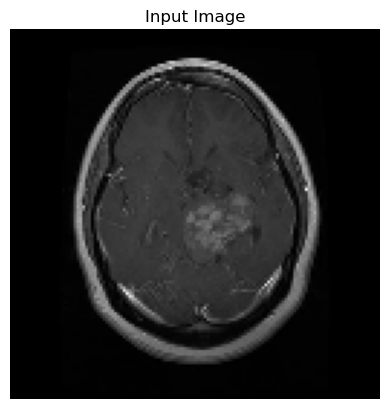

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step

Image: 1.jpg
Predicted Class: Glioma
Confidence: 1.0000



In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

IMG_SIZE = (128, 128)
CLASS_NAMES = ["Glioma", "Meningioma", "Pituitary", "No Tumor"]

# Load saved model
model = tf.keras.models.load_model("zfnet_brain_tumor_model.keras")

def predict_image(img_path):
    # Load and show image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Convert to array & preprocess
    img_arr = image.img_to_array(img)
    img_arr = img_arr / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Predict
    pred = model.predict(img_arr)
    class_id = np.argmax(pred[0])
    confidence = float(np.max(pred[0]))

    print("\n=========================")
    print(f"Image: {img_path}")
    print(f"Predicted Class: {CLASS_NAMES[class_id]}")
    print(f"Confidence: {confidence:.4f}")
    print("=========================\n")

# ----------- USE THIS -------------
predict_image("1.jpg")


✔ Model Loaded for Inference: zfnet_brain_tumor_model.keras



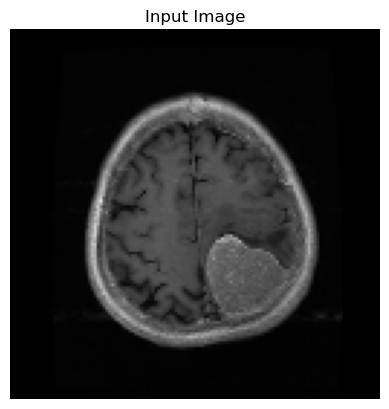

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
============== Result ==============
Image Path      : 2.jpg
Predicted Tumor : Meningioma
Confidence      : 0.9996



In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ---------------------------
# Settings
# ---------------------------
IMG_SIZE = (128, 128)
CLASS_NAMES = ["Glioma", "Meningioma", "Pituitary", "No Tumor"]
MODEL_PATH = "zfnet_brain_tumor_model.keras"

# ---------------------------
# Load Model (no optimizer)
# ---------------------------
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

def predict_image(img_path):
    print(f"\n✔ Model Loaded for Inference: {MODEL_PATH}\n")

    # Load and show the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Prepare image
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Predict
    pred = model.predict(img_arr)
    class_id = np.argmax(pred)
    confidence = np.max(pred)

    print("============== Result ==============")
    print(f"Image Path      : {img_path}")
    print(f"Predicted Tumor : {CLASS_NAMES[class_id]}")
    print(f"Confidence      : {confidence:.4f}")
    print("====================================\n")

# ---------------------------
# Run Prediction
# ---------------------------
predict_image("2.jpg")